PNEUMONIA CLASSIFICATION USING CONVOLUTIONAL NEURAL NETWORKS

CONTEXT

Pneumonia is an infection in one or both lungs. It causes the alveoli of the lungs to fill with fluid or pus. It can range from mild to severe, depending on the type of germ causing the infection, your age, and your general health.

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

source: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

In [64]:
#Necessary libraries

import torch # Data structures to multidimensional tensors
import torch.nn.functional as F # Contains the functions of the torch.nn library
from torch import nn #Basic building blocks for graphs
import torchvision.transforms as transforms

#plot libs
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

#sklearn libs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#numpy libs
import numpy as np

#Another libs
import os
import cv2

import random

In [102]:
if torch.cuda.is_available():
    print('Can use GPU')
else:
    print('Cant use GPU, using CPU')

Cant use GPU, using CPU


1.Data exploration

In [66]:
#Datafoler
print(os.listdir("C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray"))

['.DS_Store', 'test', 'train', 'val']


In [67]:
#What is in each subset folder
print(os.listdir("C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/train"))
print(os.listdir("C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/test"))
print(os.listdir("C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/val"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']
['.DS_Store', 'NORMAL', 'PNEUMONIA']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [68]:
#Files in each subfolder
TrainPath="C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/train/"
TestPath="C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/test/"
ValPath="C:/Users/PERSONAL/OneDrive/Datascience/CNN_PneumoniaClassifier/chest_xray/val/"
TrainFiles={'PATH':TrainPath,'NORMAL':None,'PNEUMONIA':None}
TestFiles={'PATH':TestPath,'NORMAL':None,'PNEUMONIA':None}
ValFiles={'PATH':ValPath,'NORMAL':None,'PNEUMONIA':None}
NSubsetFile=[TrainFiles,TestFiles,ValFiles]
for data in NSubsetFile:
    try:
        data['NORMAL']=(os.listdir(data['PATH']+'NORMAL/'))
        data['NORMAL'].remove('.DS_Store')
    except ValueError:
        print('Not .DS_Store file in folder but all right')
        pass
    try:
        data['PNEUMONIA']=(os.listdir(data['PATH']+'PNEUMONIA'))
        data['PNEUMONIA'].remove('.DS_Store')
    except ValueError as e:
        print('Not .DS_Store file in folder but all right')
        pass


Not .DS_Store file in folder but all right
Not .DS_Store file in folder but all right


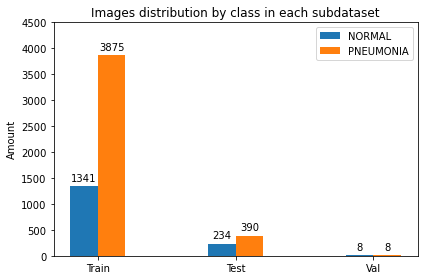

In [69]:
N=3 #Rectangles
ind = np.arange(N)
fig, ax = plt.subplots()
width=0.2
#Bar plots
rects1 = ax.bar(ind,(len(TrainFiles['NORMAL']),len(TestFiles['NORMAL']),len(ValFiles['NORMAL'])), width, label='NORMAL')
rects2 = ax.bar(ind+width , (len(TrainFiles['PNEUMONIA']),len(TestFiles['PNEUMONIA']),len(ValFiles['PNEUMONIA'])) ,width, label='PNEUMONIA')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Images distribution by class in each subdataset')
#ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim(0,4500)#Y axis limit

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.xticks(ind + width / 2, ('Train', 'Test', 'Val'))

fig.tight_layout()
plt.show()

There is a large imbalance between the amount of data for each class in training set, a minor imbalance in  test set, and a balance of classes in  validation.

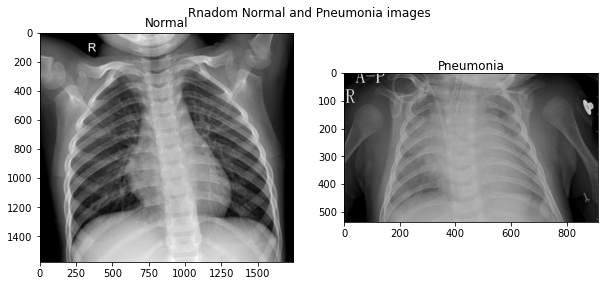

In [70]:
# Showing some random dataset images
Normal_rand,Pneumonia_rand=random.randint(0, 1342),random.randint(0, 3876)
fig, axs = plt.subplots(1,2,figsize=(10,20))
fig.suptitle('Random Normal and Pneumonia images',y=0.6)
axs[0].imshow(cv2.imread(TrainFiles['PATH']+'NORMAL/'+TrainFiles['NORMAL'][Normal_rand]))
axs[0].set_title('Normal');
axs[1].imshow(cv2.imread(TrainFiles['PATH']+'PNEUMONIA/'+TrainFiles['PNEUMONIA'][Normal_rand]))
axs[1].set_title('Pneumonia',pad=0);

In [71]:
def Images_dimensions(subsetdictionary):
    """
    Given a subset ('train','test','val) return a list with the dimensions of each images in that folder

    :subset: folder that contains Normal and Pneumonia folder where each folder contains the images

    :return: Dictionary with values for each dimensions
    """ 
    path=subsetdictionary['PATH']
    Dimensions={'Height':list(),'Width':list(),'Channels':list()}
    #Probar con un solo try except
    for normal in subsetdictionary['NORMAL']:
        x,y,z=(cv2.imread(path+'/NORMAL/'+normal).shape)
        Dimensions['Height'].append(x);Dimensions['Width'].append(y);Dimensions['Channels'].append(z)
    for pneumonia in subsetdictionary['PNEUMONIA']:
        x,y,z=(cv2.imread(path+'/PNEUMONIA/'+pneumonia).shape)
        Dimensions['Height'].append(x);Dimensions['Width'].append(y);Dimensions['Channels'].append(z)
    return Dimensions

In [72]:
#Dimensions values for each subfolder
Train_dimensions=Images_dimensions(TrainFiles);
Test_dimensions=Images_dimensions(TestFiles);
Val_dimensions=Images_dimensions(ValFiles);

In [73]:
#Values for each dimension
Heights=[*Train_dimensions['Height'],*Test_dimensions['Height'],*Val_dimensions['Height']]
Widths=[*Train_dimensions['Width'],*Test_dimensions['Width'],*Val_dimensions['Width']]
Channels=[*Train_dimensions['Channels'],*Test_dimensions['Channels'],*Val_dimensions['Channels']]

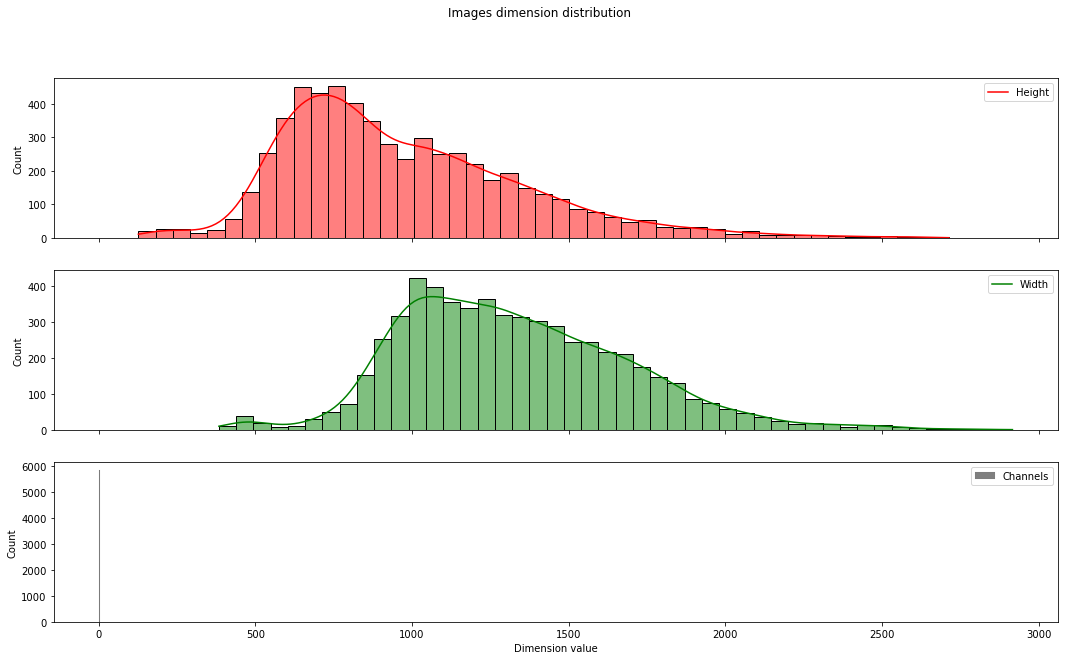

In [74]:
#Plotting results
figure,axes= plt.subplots(3, 1, sharex=True,sharey=False,figsize=(18, 10))
figure.suptitle("Images dimension distribution")
sns.histplot(ax=axes[0],data=Heights,kde=True,color='red',stat='count')
sns.histplot(ax=axes[1],data=Widths,kde=True,color='green',stat='count')
sns.histplot(ax=axes[2],data=Channels,kde=True,color='black',stat='count')
axes[0].legend(['Height'])
axes[1].legend(['Width'])
axes[2].legend(['Channels'])
axes[2].set_xlabel('Dimension value');


It is observed that all the images have the same number of channels, however the distribution of values for each dimension is variable and different for height and width.

In [75]:
import warnings
warnings.filterwarnings('ignore')

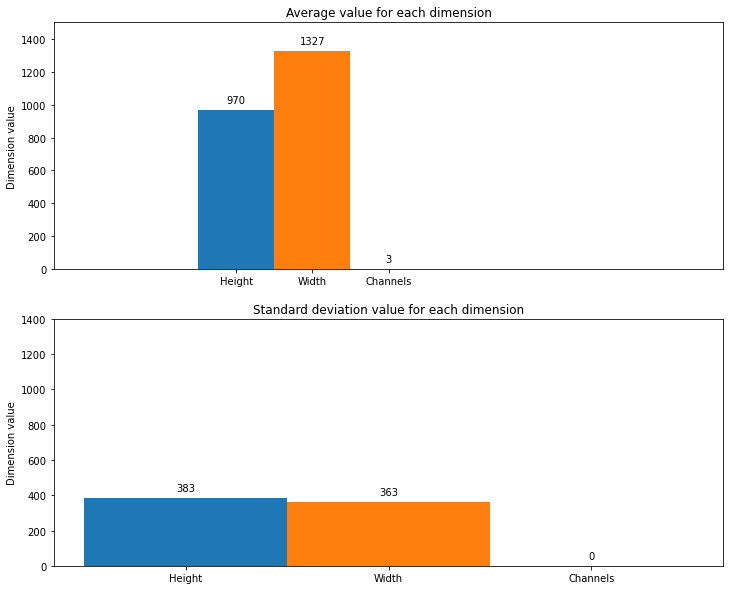

In [76]:
#Bar plots
x = 0.2  # Label location
width = 0.1  # Width of bars
fig, ax = plt.subplots(2,figsize=(12,10))

#Average value of each dimension
Height_mean=np.mean(Heights,dtype=np.int32)
Width_mean=np.mean(Widths,dtype=np.int32)
Channels_mean=np.mean(Channels,dtype=np.int32)

#Bar plots
rects1 = ax[0].bar(x - width,Height_mean , width)
rects2 = ax[0].bar(x , Width_mean, width)
rects3 = ax[0].bar(x + width, Channels_mean)

#Custom labels,tittles,axis,etc.

ax[0].set_ylabel('Dimension value')
ax[0].set_title('Average value for each dimension')
ax[0].set_xticklabels(["Height","Width","Channels"])
ax[0].set_xticks([x-width,x,x+width])
#ax[0].legend()
ax[0].set_ylim(0,1500)
ax[0].bar_label(rects1, padding=5)
ax[0].bar_label(rects2, padding=5)
ax[0].bar_label(rects3, padding=5)
#plt.show()

#Standard deviation value of each dimension
Height_std=np.std(Heights,dtype=np.int32)
Width_std=np.std(Widths,dtype=np.int32)
Channels_std=np.std(Channels,dtype=np.int32)

x=0.01
#Bar plots
rects1 = ax[1].bar(x - width,Height_std , width)
rects2 = ax[1].bar(x , Width_std, width)
rects3 = ax[1].bar(x + width, Channels_std, width)

#Custom labels,tittles,axis,etc.
ax[1].set_ylabel('Dimension value')
ax[1].set_title('Standard deviation value for each dimension')
ax[1].set_xticklabels(["Height","Width","Channels"])
ax[1].set_xticks([x-width,x,x+width])
#ax[1].legend()
ax[1].set_ylim(0,1400)
ax[1].bar_label(rects1, padding=5)
ax[1].bar_label(rects2, padding=5)
ax[1].bar_label(rects3, padding=5)

plt.show() 

It is clear that all the images have the same number of channels (3), different to the height and width where hight deviation occurs.


2. PRE PROCCESING DATA

As noted above, the data has two main characteristics that could pose a problem:

1) Class imbalance, there are more images for the PNEUMONIA class than for NORMAL, which could generate problems in the training of the neural network since it would learn mainly the one with the greatest number of examples.

2) Dimension of the images, the images present a large variation in their dimensions both for height and width, in addition, on average, these dimensions have a very high value, which is computationally quite expensive and a better device would be required for processing them.

To solve these two problems, a filter will be carried out on the type of pneumonia for the training and test set, the filter criterion corresponds to the fact that only those images whose height and width are between the average will be used. ± a standard deviation, thus obtaining a smaller number of images for pneumonia in addition to eliminating a little the variance between them.
The images will be resized to 212x212x3 which, although they are lower values than the average dimensions, will allow reducing the exaggerated computational cost that the deployment of the model would require for such large values of dimensions.

In [77]:
def Filter_image(subset,x_mean,y_mean,x_std,y_std):
    """
    Given a subset ('train','test','val) return a list with pneumonia files that are under the criterion.
    The criterion is that the height and weidth for image are between mean ± standard deviation.

    :return: List of files names that are under the criterion.
    """ 
    path=subset['PATH']

    Lowx_criterio,Lowy_criterio=(x_mean-x_std),(y_mean-y_std)
    Highx_criterio,Highy_criterio=(x_mean+x_std),(y_mean+y_std)
    print('Height criterio',Lowx_criterio,Lowy_criterio)
    print('Weight criterio',Highx_criterio,Highy_criterio)
    Pneumonia_images=list()
    #Probar con un solo try except
    for file in subset['PNEUMONIA']:
        #print(path)
        #print(file)
        image=cv2.imread(path+'PNEUMONIA/'+file)
        x,y,*_=image.shape
        if (Lowx_criterio<x<Highx_criterio) and (Lowy_criterio<y<Highy_criterio):
            Pneumonia_images.append(file)
    return Pneumonia_images

In [78]:
TrainFiles['PNEUMONIA']=Filter_image(TrainFiles,Height_mean,Width_mean,Height_std,Width_std)
TestFiles['PNEUMONIA']=Filter_image(TestFiles,Height_mean,Width_mean,Height_std,Width_std)

Height criterio 587 964
Weight criterio 1353 1690
Height criterio 587 964
Weight criterio 1353 1690


In [79]:
print(len(TrainFiles['PNEUMONIA']))
print(len(TestFiles['PNEUMONIA']))

2696
282


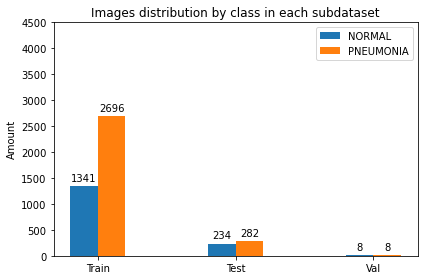

In [80]:
N=3
ind = np.arange(N)
fig, ax = plt.subplots()
width=0.2
#Bar plots
rects1 = ax.bar(ind,(len(TrainFiles['NORMAL']),len(TestFiles['NORMAL']),len(ValFiles['NORMAL'])), width, label='NORMAL')
rects2 = ax.bar(ind+width , (len(TrainFiles['PNEUMONIA']),len(TestFiles['PNEUMONIA']),len(ValFiles['PNEUMONIA'])) ,width, label='PNEUMONIA')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Images distribution by class in each subdataset')
#ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim(0,4500)#Y axis limit

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.xticks(ind + width / 2, ('Train', 'Test', 'Val'))

fig.tight_layout()
plt.show()

Although the classes are not perfectly balanced for both training and testing, the imbalance of the data was considerably reduced. Which is expected to improve model training.

3. DATA EXTRACTION

In [81]:
def get_data(subsetdir):
    '''
    Given a subset ('train','test','val) return a list with the images resized to 212x212x3 and another list with their respective label class. 
    '''
    image = []
    label = [] 
    for file in subsetdir['PNEUMONIA']:
        img=cv2.imread(subsetdir['PATH']+'PNEUMONIA/'+file)
        img=cv2.resize(img,(212,212))
        image.append(img)
        label.append(1)
    for file in subsetdir['NORMAL']:
        img=cv2.imread(subsetdir['PATH']+'NORMAL/'+file)
        img=cv2.resize(img,(212,212))
        image.append(img)
        label.append(0)
    return image,label

In [82]:
#Getting data from every subset
train_data,train_label=get_data(TrainFiles)
test_data,test_label=get_data(TestFiles)
val_data,val_label=get_data(ValFiles)

In [83]:
#Deleting variables that are no longer required in the code so as not to overflow memory
del TrainPath,TestPath,ValPath,Train_dimensions,Test_dimensions,Val_dimensions,Channels,Heights,Widths,NSubsetFile,TrainFiles,TestFiles,ValFiles

In [84]:
from torch.utils.data import Dataset, DataLoader
#Pytorch data management
class CustomImageDataset(Dataset): #Customized data
    def __init__(self,images,labels,transforms):
        self.image=images
        self.label=torch.LongTensor(labels)
        self.transforms=transforms

    def __len__(self): # To return the size
        return len(self.label) 
        
    def __getitem__(self,idx):#To get the idx sample
        y=self.label[idx]
        x=self.image[idx]/255 #Normalizing
        
        if self.transforms:
           img=self.transforms(x).float()
           #numpy uses float64 as their default type, so call float() on these tensors before passing them to the
        sample= img,y

        return sample

In [85]:
T=transforms.ToTensor() #Transform image into tensor       

In [86]:
#Customizing the 3 subsets
Trainset=CustomImageDataset(train_data,train_label,T)
Testset=CustomImageDataset(test_data,test_label,T)
Valset=CustomImageDataset(val_data,val_label,T)

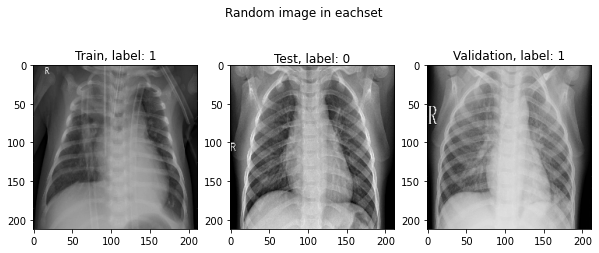

In [100]:
#Showing some randoms image in each subset with their respective label class.
Train_randidx,Test_randidx,Val_randidx=random.randint(0, Trainset.__len__()-1),random.randint(0, Testset.__len__()-1),random.randint(0, Valset.__len__()-1)
fig, axs = plt.subplots(1,3,figsize=(10,20))
fig.suptitle('Random image in eachset',y=0.6)
axs[0].imshow(Trainset[Train_randidx][0].permute(1, 2, 0))
axs[0].set_title(f'Train, label: {Trainset[Train_randidx][1]}');
axs[1].imshow(Testset[Test_randidx][0].permute(1, 2, 0))
axs[1].set_title(f'Test, label: {Testset[Test_randidx][1]}',pad=0);
axs[2].imshow(Valset[Val_randidx][0].permute(1, 2, 0))
axs[2].set_title(f'Validation, label: {Valset[Val_randidx][1]}');

In [88]:
mbsize=64#Mini batch size
#Dataloader provide a iterable object and and generate the mini-batches
train_loader = DataLoader(dataset=Trainset,
                          batch_size=mbsize,
                          shuffle=True)
                          
test_loader = DataLoader(dataset=Testset,
                          batch_size=1,
                          shuffle=False)

val_loader = DataLoader(dataset=Valset,
                          batch_size=1,
                          shuffle=False)

4. Convolutional neural network arquitecture and results

In [89]:
'''To build neural network arquitectura we need
torch.nn as nn and torch.nn.functional as F'''

class ConvolutionalNeuralNetwork(nn.Module):

    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # 3 input image channel, 6 output channels, 2x2 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.conv3 = nn.Conv2d(16, 32, 2)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(800,600) 
        self.fc2 = nn.Linear(600, 450) 
        self.fc3 = nn.Linear(450, 150)
        self.fc4 = nn.Linear(150, 75)
        self.fc5 = nn.Linear(75, 2)

    def forward(self, x):
        #print("Input: ",x.shape)
        #Convolutional layers)
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (4, 4))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.leaky_relu(self.conv3(x)), (4, 4))
        #Flatten layers
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [90]:
torch.cuda.empty_cache()
torch.manual_seed(30)
model = ConvolutionalNeuralNetwork()

In [91]:
def Train_loop(model,trainloader,num_epochs,optimizer,loss_function):
    losses=[] #List to store losses values
    loss=0;
    epochs=range(num_epochs)
    Batches=len(train_loader)
    model.train() #Model train mode
    for epoch in range(num_epochs): #Iterating over num epoch
        print(f'Epoch{epoch+ 1}')
        for i,(xi,yi) in enumerate(trainloader): #Iterating over mini batch
            showbatch=(lambda i:print(f'Batch {i}/{Batches-1}') if (i%32 == 0 or i==Batches-1) else None)
            showbatch(i)
            optimizer.zero_grad() #Reset gradients to zero to avoid accumulation
            #print(f'Batch{i}')
            #Forward pass
            y_pred=model.forward(xi) 
            #Loss
            loss=loss_function(y_pred,yi)
            #Backward propagation
            loss.backward()
            optimizer.step()
        losses.append(loss.item())#Add loss value each epoch         
            
    return epochs,losses 

In [92]:
loss_function = nn.CrossEntropyLoss() #Cross entropy loss fuction
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Implements adam algorithm
num_epochs=10;#Num of epochs
epoch,final_losses=Train_loop(model,train_loader,num_epochs,optimizer,loss_function) #Train the model

Epoch1
Batch 0/63
Batch 32/63
Batch 63/63
Epoch2
Batch 0/63
Batch 32/63
Batch 63/63
Epoch3
Batch 0/63
Batch 32/63
Batch 63/63
Epoch4
Batch 0/63
Batch 32/63
Batch 63/63
Epoch5
Batch 0/63
Batch 32/63
Batch 63/63
Epoch6
Batch 0/63
Batch 32/63
Batch 63/63
Epoch7
Batch 0/63
Batch 32/63
Batch 63/63
Epoch8
Batch 0/63
Batch 32/63
Batch 63/63
Epoch9
Batch 0/63
Batch 32/63
Batch 63/63
Epoch10
Batch 0/63
Batch 32/63
Batch 63/63


In [93]:
#Prediction values function
def prediction_loop(model,testdataset):
    predictions = [] #List to store predictions 
    labels=[] #List to store correct labels (diabetes or not)
    model.eval() #Evaluation mode
    with torch.no_grad(): #Dissable gradients calculations
        for i,(xi,yi) in enumerate(testdataset): #Iteration over data
            #print(f'Input {i}')
            #Forward pass
            y_pred = model.forward(xi) 
            predictions.append(y_pred.argmax().item()) #Which index is maximum using .argmax(); 0 or 1.
            labels.append(yi.item())
    return labels,predictions

In [94]:
#Test set
labels,predictions=prediction_loop(model,test_loader)
print(len(labels),len(predictions))

516 516


In [95]:
print("Test accuracy is {}%".format(round(accuracy_score(labels,predictions)*100),2))

Test accuracy is 75%


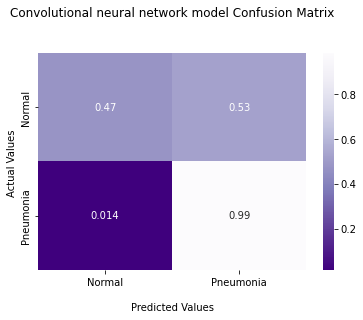

              precision    recall  f1-score   support

      Normal       0.97      0.47      0.64       234
   Pneumonia       0.69      0.99      0.81       282

    accuracy                           0.75       516
   macro avg       0.83      0.73      0.73       516
weighted avg       0.82      0.75      0.73       516




In [96]:
cf_matrix = confusion_matrix(labels, predictions,normalize='true')#Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
cf_results=classification_report(labels, predictions,target_names=['Normal','Pneumonia']); #Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples_r') #confusion matrix heatmap

ax.set_title('Convolutional neural network model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cf_results)
print()

The model has a relatively good precision, however, analyzing the recall, it stands out that it has a very high value for the PNEUMONIA class, however it is much lower for the NORMAL class, so according to these results the model is very effective in giving a effective forecast on pneumonia however it presents problems for those healthy subjects.

In [97]:
#Validation 
labels,predictions=prediction_loop(model,val_loader)

In [101]:
print("Validation accuracy is: {}%".format(round(accuracy_score(labels,predictions)*100),2))

Validation accuracy is: 88%


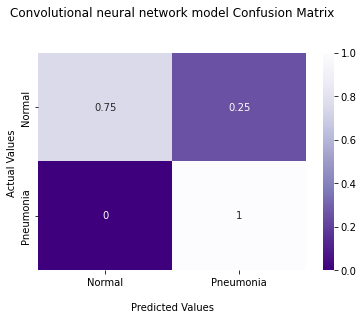

              precision    recall  f1-score   support

      Normal       1.00      0.75      0.86         8
   Pneumonia       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16




In [99]:
cf_matrix = confusion_matrix(labels, predictions,normalize='true')#Confusion matrix normalized
tn, fp, fn, tp = (cf_matrix).ravel() #True negatives, false positives, false negativas and true positives
cf_results=classification_report(labels, predictions,target_names=['Normal','Pneumonia']); #Clasification report

ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples_r') #confusion matrix heatmap

ax.set_title('Convolutional neural network model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show()

print(cf_results)
print()

In validating the results in statistical terms they were significantly better with better precision and based on recall a better ability of the model to distinguish the two different classes.

5.Conclusions

The results of the model were good, however, since it is a health problem, the results could be considerably better in order to provide greater security in the predictions and therefore in the health of the patient who would be subjected to a diagnosis using this AI.

Other options that could be experimented with if better results are obtained are:

Do not filter the images and work with all the images.

Use other hyperparameters.

Use a larger dimension for the images (It would require a better equipment).

Use another neural network.